## K-Means Clustering — End-to-End Workflow (Unsupervised)

We’ll build an unsupervised pipeline using K-Means:
	•	Data Exploration: synthesize blobs with different spreads + a little noise
	•	Preprocessing: standardize features (very important for K-Means)
	•	Modeling: from-scratch K-Means and scikit-learn KMeans; pick k via Elbow & Silhouette
	•	Evaluation: inertia, silhouette, and (since we know the synthetic truth) ARI/NMI

Concept: K-Means partitions data into k clusters by minimizing within-cluster sum of squares (inertia).
Key hyperparameters: n_clusters (k), init (k-means++), n_init, max_iter, tol, random_state.

## Setup

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, List, Dict
from IPython.display import display

# sklearn utilities
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.4)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll generate a 2-D dataset from three Gaussian blobs with different standard deviations and add a few uniform outliers.

Shape: (960, 3)


,x1,x2,y_ref
0,4.401177,0.616299,1
1,0.608579,3.760658,2
2,1.648490,0.151069,1
3,-2.091071,-0.647010,0
4,0.245487,3.367439,2


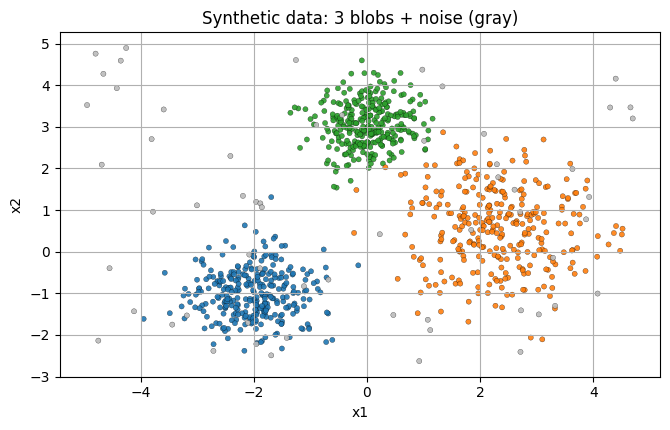

In [2]:
# Blobs + a few uniform outliers
X_core, y_true = make_blobs(
    n_samples=900,
    centers=[(-2, -1), (2.2, 0.5), (0.0, 3.0)],
    cluster_std=[0.6, 0.9, 0.5],
    random_state=42
)
n_out = 60
X_noise = np.random.uniform(low=[-5, -3], high=[5, 5], size=(n_out, 2))
y_noise = -np.ones(n_out, dtype=int)  # for reference only

X = np.vstack([X_core, X_noise])
y_ref = np.concatenate([y_true, y_noise])  # ground truth-ish (noise = -1)

df = pd.DataFrame(X, columns=["x1", "x2"])
df["y_ref"] = y_ref

print("Shape:", df.shape)
display(df.head())

# Quick scatter by reference labels (noise in gray)
palette = {0: "tab:blue", 1: "tab:orange", 2: "tab:green", -1: "#BBBBBB"}
colors = [palette[v] for v in y_ref]
plt.scatter(df.x1, df.x2, c=colors, s=14, edgecolor="k", linewidths=0.2, alpha=0.9)
plt.title("Synthetic data: 3 blobs + noise (gray)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.tight_layout(); plt.show()

## Preprocessing
	•	Standardize features (K-Means uses Euclidean distance; scale matters)
	•	We’ll prepare helpers to plot elbow and silhouette to select k

In [3]:
# Standardize features
scaler = StandardScaler()
Xs = scaler.fit_transform(df[["x1", "x2"]].to_numpy())

def elbow_curve(X: np.ndarray, k_min: int = 1, k_max: int = 10, **km_kwargs):
    ks, inertias = [], []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42, **km_kwargs)
        km.fit(X)
        ks.append(k)
        inertias.append(km.inertia_)
    plt.plot(ks, inertias, marker="o")
    plt.xlabel("k (n_clusters)"); plt.ylabel("Inertia (within-SS)")
    plt.title("Elbow curve")
    plt.xticks(ks)
    plt.tight_layout(); plt.show()
    return ks, inertias

def silhouette_summary(X: np.ndarray, k_values: List[int]):
    rows = []
    for k in k_values:
        if k < 2:
            rows.append((k, np.nan))
            continue
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
        labels = km.fit_predict(X)
        s = silhouette_score(X, labels)
        rows.append((k, s))
    tab = pd.DataFrame(rows, columns=["k", "silhouette"])
    display(tab.sort_values("silhouette", ascending=False))
    return tab

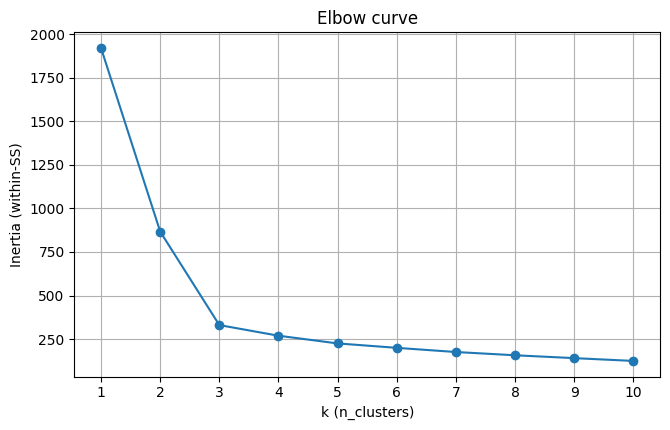

,k,silhouette
1,3,0.648020
3,5,0.582278
2,4,0.571112
0,2,0.550794
4,6,0.450624
5,7,0.433115
6,8,0.332448
7,9,0.330972


In [4]:
# Inspect elbow & silhouette to pick k
_ = elbow_curve(Xs, k_min=1, k_max=10)
sil_tab = silhouette_summary(Xs, k_values=list(range(2, 10)))

## Modeling

We’ll train:
	1.	From-scratch K-Means (k-means++, inertia, empty-cluster repair)
	2.	scikit-learn KMeans with the chosen k from plots (usually ~3 here)
We’ll also visualize the clusters and centroids.

In [5]:
class SimpleKMeans:
    """
    Minimal K-Means with k-means++ initialization.
    - metric: Euclidean in standardized space
    - empty cluster repair: re-seed to farthest point
    """
    def __init__(self, n_clusters: int = 3, max_iter: int = 300, tol: float = 1e-4, random_state: Optional[int] = 42):
        self.n_clusters = int(n_clusters)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.random_state = random_state

        self.cluster_centers_: Optional[np.ndarray] = None
        self.labels_: Optional[np.ndarray] = None
        self.inertia_: Optional[float] = None

    def _init_plus_plus(self, X: np.ndarray, rng: np.random.RandomState):
        n = X.shape[0]
        centers = []
        # choose first center uniformly
        i0 = rng.randint(n)
        centers.append(X[i0])
        # choose subsequent centers with prob ∝ D(x)^2
        for _ in range(1, self.n_clusters):
            d2 = np.min(((X[:, None, :] - np.array(centers)[None, :, :]) ** 2).sum(axis=2), axis=1)
            probs = d2 / (d2.sum() + 1e-12)
            idx = rng.choice(n, p=probs)
            centers.append(X[idx])
        return np.vstack(centers)

    @staticmethod
    def _assign(X: np.ndarray, C: np.ndarray) -> np.ndarray:
        # squared distances to each center
        d2 = ((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2)
        return np.argmin(d2, axis=1)

    @staticmethod
    def _update(X: np.ndarray, labels: np.ndarray, k: int, C: np.ndarray) -> np.ndarray:
        newC = C.copy()
        for j in range(k):
            mask = labels == j
            if np.any(mask):
                newC[j] = X[mask].mean(axis=0)
            else:
                # empty cluster: re-seed to farthest point from current centers
                d2 = np.min(((X[:, None, :] - C[None, :, :]) ** 2).sum(axis=2), axis=1)
                idx = np.argmax(d2)
                newC[j] = X[idx]
        return newC

    def fit(self, X: np.ndarray):
        rng = np.random.RandomState(self.random_state)
        C = self._init_plus_plus(X, rng)

        for _ in range(self.max_iter):
            labels = self._assign(X, C)
            newC = self._update(X, labels, self.n_clusters, C)
            shift = np.linalg.norm(newC - C)
            C = newC
            if shift <= self.tol:
                break

        self.cluster_centers_ = C
        self.labels_ = self._assign(X, C)
        # inertia
        d2 = ((X - C[self.labels_]) ** 2).sum(axis=1)
        self.inertia_ = float(d2.sum())
        return self

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        self.fit(X)
        return self.labels_

In [6]:
# Choose k (use the best silhouette from the earlier table, else set k=3)
k_choice = int(sil_tab.iloc[sil_tab["silhouette"].argmax()]["k"]) if sil_tab["silhouette"].notna().any() else 3
print("Chosen k =", k_choice)

# 1) From-scratch
kmeans_scratch = SimpleKMeans(n_clusters=k_choice, max_iter=300, tol=1e-4, random_state=42)
labels_scratch = kmeans_scratch.fit_predict(Xs)

# 2) scikit-learn KMeans
kmeans_sk = KMeans(n_clusters=k_choice, init="k-means++", n_init=20, max_iter=300, random_state=42)
labels_sk = kmeans_sk.fit_predict(Xs)

Chosen k = 3


## Evaluation

We’ll report inertia and silhouette. Because we know the generating clusters (ignoring uniform noise), we also compute ARI/NMI.

In [7]:
def summarize(X: np.ndarray, labels: np.ndarray, inertia: float) -> Dict[str, float]:
    uniq = np.unique(labels)
    k_eff = len(uniq)
    sil = np.nan
    if k_eff >= 2 and (labels != labels[0]).any():
        sil = silhouette_score(X, labels)
    return {"k": k_eff, "inertia": inertia, "silhouette": sil}

def external_scores(y_ref_all: np.ndarray, labels_all: np.ndarray) -> Tuple[float, float]:
    # compare only points that are NOT uniform noise in the reference (i.e., y_ref != -1)
    mask = y_ref_all != -1
    if mask.sum() == 0:
        return (np.nan, np.nan)
    yt = y_ref_all[mask]
    yp = labels_all[mask]
    # need at least 2 clusters
    if len(np.unique(yp)) < 2 or len(np.unique(yt)) < 2:
        return (np.nan, np.nan)
    return adjusted_rand_score(yt, yp), normalized_mutual_info_score(yt, yp)

sum_scratch = summarize(Xs, labels_scratch, kmeans_scratch.inertia_)
sum_sk = summarize(Xs, labels_sk, kmeans_sk.inertia_)

ari_scratch, nmi_scratch = external_scores(y_ref, labels_scratch)
ari_sk, nmi_sk = external_scores(y_ref, labels_sk)

print("\n=== KMeans (scratch) ===")
print(sum_scratch, f" | ARI={ari_scratch:.3f}, NMI={nmi_scratch:.3f}")
print("Centers (std space):\n", kmeans_scratch.cluster_centers_)

print("\n=== KMeans (sklearn) ===")
print(sum_sk, f" | ARI={ari_sk:.3f}, NMI={nmi_sk:.3f}")
print("Centers (std space):\n", kmeans_sk.cluster_centers_)


=== KMeans (scratch) ===
{'k': 3, 'inertia': 330.3662146010629, 'silhouette': 0.6481542840793427}  | ARI=0.961, NMI=0.945
Centers (std space):
 [[-1.06079525 -1.00320087]
 [-0.06779568  1.17663124]
 [ 1.18403511 -0.19327292]]

=== KMeans (sklearn) ===
{'k': 3, 'inertia': 330.3605142573564, 'silhouette': 0.648019821094256}  | ARI=0.957, NMI=0.939
Centers (std space):
 [[ 1.18403511 -0.19327292]
 [-1.06131807 -1.00703451]
 [-0.07030827  1.17376061]]


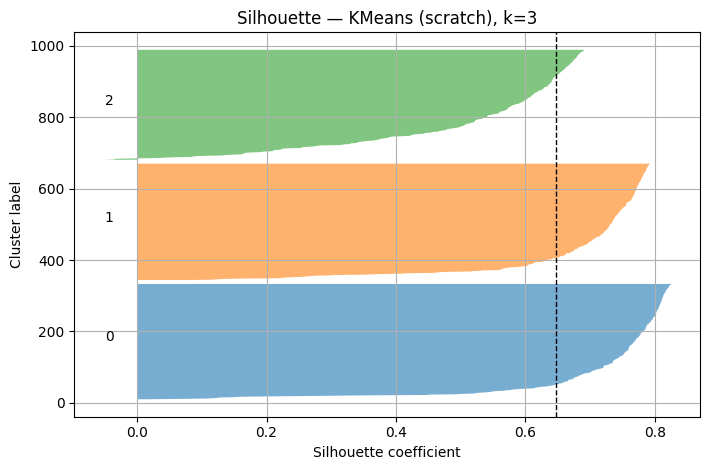

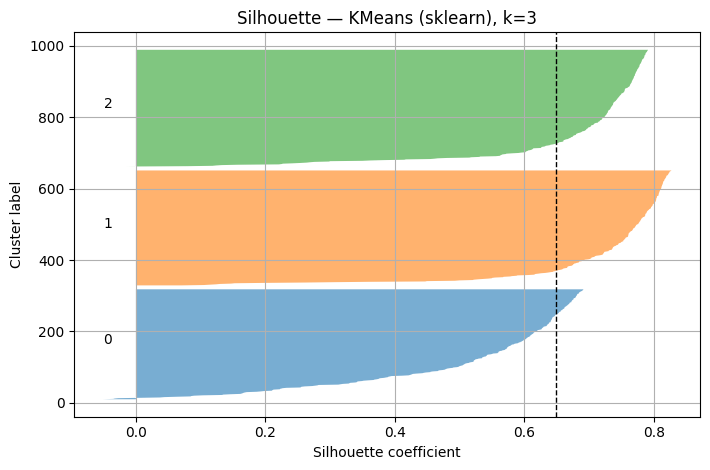

In [8]:
# Silhouette plot utility
def silhouette_plot(X: np.ndarray, labels: np.ndarray, title: str):
    uniq = np.unique(labels)
    if len(uniq) < 2:
        print(f"{title}: need >= 2 clusters for silhouette")
        return
    s = silhouette_samples(X, labels)
    y_lower = 10
    plt.figure(figsize=(7.2, 4.8))
    for k in sorted(uniq):
        s_k = s[labels == k]
        s_k.sort()
        y_upper = y_lower + len(s_k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, s_k, alpha=0.6)
        plt.text(-0.05, y_lower + 0.5 * len(s_k), str(k))
        y_lower = y_upper + 10
    plt.axvline(np.mean(s), color="k", linestyle="--", linewidth=1)
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster label")
    plt.title(title)
    plt.tight_layout(); plt.show()

silhouette_plot(Xs, labels_scratch, f"Silhouette — KMeans (scratch), k={k_choice}")
silhouette_plot(Xs, labels_sk,      f"Silhouette — KMeans (sklearn), k={k_choice}")

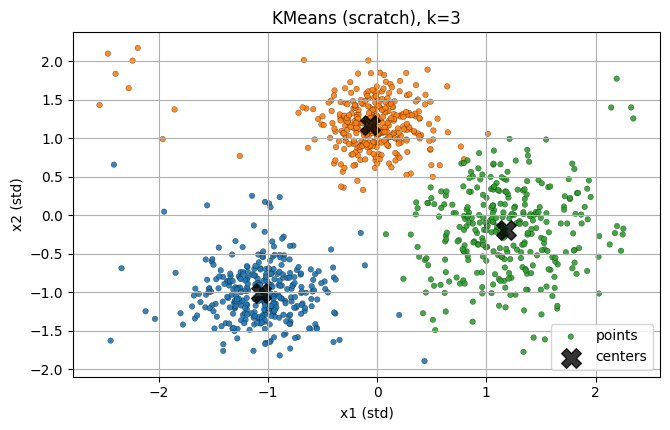

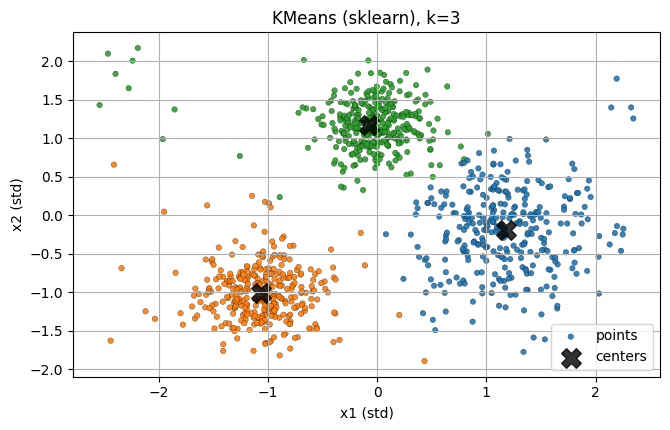

In [9]:
# 2D scatter with centers (back in standardized space)
def plot_clusters_std(X: np.ndarray, labels: np.ndarray, centers: np.ndarray, title: str):
    cmap = plt.get_cmap("tab10")
    uniq = np.unique(labels)
    cs = [cmap(int(l) % 10) for l in labels]
    plt.scatter(X[:,0], X[:,1], c=cs, s=16, edgecolor="k", linewidths=0.2, alpha=0.9, label="points")
    plt.scatter(centers[:,0], centers[:,1], marker="X", s=200, c="black", alpha=0.8, label="centers")
    plt.title(title); plt.xlabel("x1 (std)"); plt.ylabel("x2 (std)")
    plt.legend()
    plt.tight_layout(); plt.show()

plot_clusters_std(Xs, labels_scratch, kmeans_scratch.cluster_centers_, f"KMeans (scratch), k={k_choice}")
plot_clusters_std(Xs, labels_sk,      kmeans_sk.cluster_centers_,      f"KMeans (sklearn), k={k_choice}")

## Key Takeaways
	•	K-Means minimizes within-cluster variance; good for globular clusters under Euclidean distance.
	•	Standardize features; choose k via Elbow (inertia) and Silhouette (cohesion/separation).
	•	Use k-means++ + higher n_init for stability.
	•	Not ideal with non-convex shapes, varying densities, or many outliers (consider DBSCAN, GMM, or spectral methods).